# Imports

In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import pathlib

import tensorflow as tf
from tensorflow import keras
from keras import layers

import struct
from array import array

import random
import time

import imageio
import PIL

import glob

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython import display

# Load in Data as Numpy Array

## Data loader class

In [43]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

## Load data

In [44]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [45]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Discriminator and Generator

In [46]:
"""
    Generates a number
    Input is a random seed of size (100,)
"""
def make_number_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

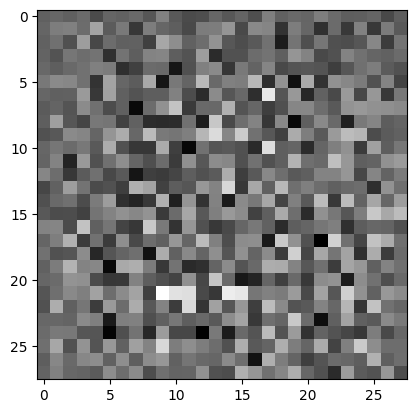

In [47]:
generator = make_number_generator()

seed = tf.random.normal([1, 100])
generated_img = generator(seed, training=False)

plt.imshow(generated_img[0, :, :, 0], cmap='gray')

In [48]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [49]:
discriminator = make_discriminator_model()
decision = discriminator(generated_img)
print(decision)

tf.Tensor([[0.00050886]], shape=(1, 1), dtype=float32)


# Define the loss and optimizers

In [50]:
# Return the loss function
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [51]:
"""
    Calculate the discriminator loss using Binary Crossentropy
    Calculates using discriminator loss from discriminating a real image (dataset) vs a fake image (generator)
"""
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [52]:
def generator_loss(fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return fake_loss

In [53]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [54]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Define the training loop

In [55]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [56]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator =  gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Train the models

In [57]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('generate_images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [58]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produces images for the GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


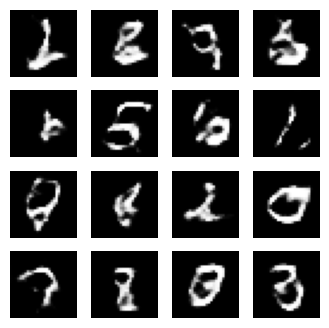

In [59]:
train(train_dataset, EPOCHS)

In [66]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('generated/image_at_epoch_{:04d}.png'.format(epoch_no))

In [67]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipykernel_33830/1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


FileNotFoundError: No such file: '/home/khoa/Documents/Projects/MINSTHandWrittenNumbers/image_at_epoch_0050.png'